# Logistic Regression with 1 Hidden Layer: Non-Linear Classification

## 🎯 What We'll Build

In this notebook, we implement **logistic regression with 1 hidden layer** - a shallow neural network for binary classification.

**Architecture:**
```
Input (2 features) → Hidden Layer (h neurons with ReLU) → Output (1 neuron with sigmoid)
```

**Key Difference from Pure Logistic Regression:**
- ✅ Has a hidden layer → Can learn **non-linear** decision boundaries!
- ✅ More expressive → Can solve more complex problems

---

## 📋 What You'll Learn

1. ✅ How hidden layers enable non-linearity
2. ✅ 2-layer neural network architecture
3. ✅ Forward propagation through hidden layer
4. ✅ Backpropagation with hidden layer gradients
5. ✅ Comparing linear vs non-linear decision boundaries
6. ✅ When to use hidden layers

Let's get started! 🚀

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## 2. Generate Synthetic 2D Data

We'll create the **same dataset** as before to compare with pure logistic regression.

In [2]:
def generate_binary_data(n_samples=200, noise=0.3):
    """
    Generate synthetic 2D binary classification data.
    """
    np.random.seed(42)
    
    # Class 0: centered around (-1, -1)
    n_class0 = n_samples // 2
    X_class0 = np.random.randn(n_class0, 2) * noise + np.array([-1, -1])
    y_class0 = np.zeros(n_class0)
    
    # Class 1: centered around (1, 1)
    n_class1 = n_samples - n_class0
    X_class1 = np.random.randn(n_class1, 2) * noise + np.array([1, 1])
    y_class1 = np.ones(n_class1)
    
    # Combine
    X = np.vstack([X_class0, X_class1])
    y = np.hstack([y_class0, y_class1])
    
    # Shuffle
    indices = np.random.permutation(n_samples)
    X = X[indices]
    y = y[indices]
    
    return X, y

# Generate data
X, y = generate_binary_data(n_samples=200, noise=0.3)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Dataset shape: {X.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Dataset shape: (200, 2)
Training samples: 140
Test samples: 60


### Visualize the Dataset

/tmp/ipython-input-1572872437.py:18: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1572872437.py:18: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


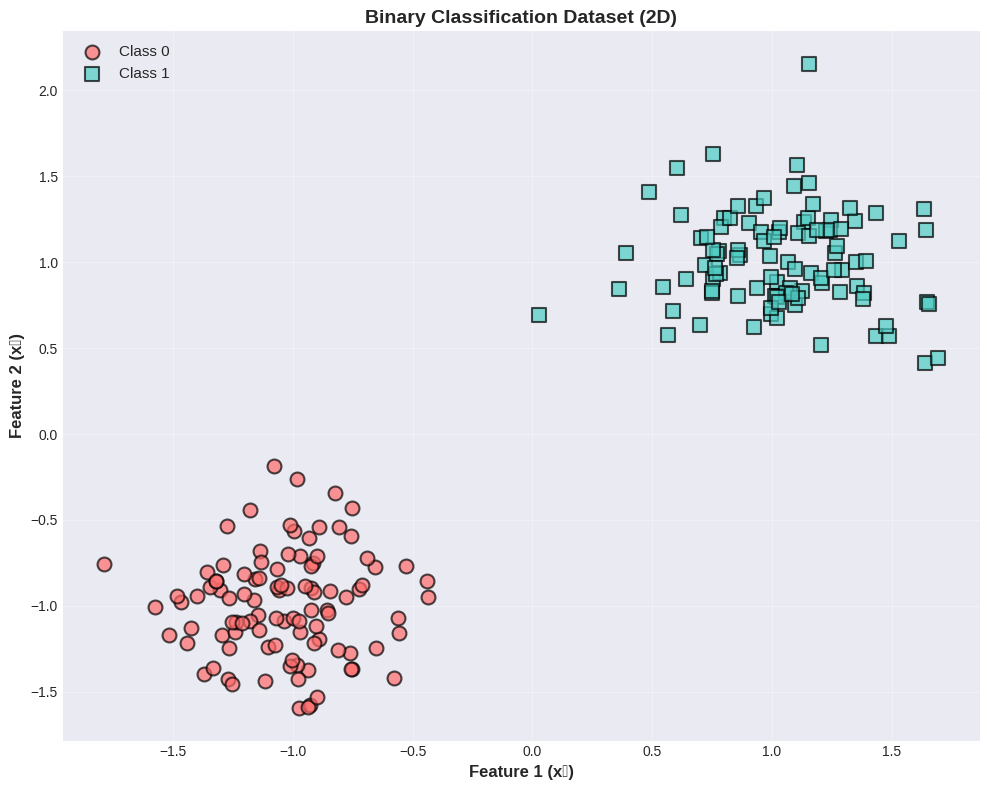


📊 Same dataset as pure logistic regression
   Now let's see how a hidden layer improves performance!


In [3]:
plt.figure(figsize=(10, 8))

plt.scatter(X[y == 0, 0], X[y == 0, 1], 
           c='#FF6B6B', s=100, alpha=0.7, 
           edgecolors='black', linewidth=1.5,
           label='Class 0', marker='o')

plt.scatter(X[y == 1, 0], X[y == 1, 1], 
           c='#4ECDC4', s=100, alpha=0.7, 
           edgecolors='black', linewidth=1.5,
           label='Class 1', marker='s')

plt.xlabel('Feature 1 (x₁)', fontsize=12, fontweight='bold')
plt.ylabel('Feature 2 (x₂)', fontsize=12, fontweight='bold')
plt.title('Binary Classification Dataset (2D)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Same dataset as pure logistic regression")
print("   Now let's see how a hidden layer improves performance!")

## 3. Logistic Regression with 1 Hidden Layer

### Architecture

```
Layer 1 (Input → Hidden):
  z1 = X @ W1 + b1
  h1 = ReLU(z1)

Layer 2 (Hidden → Output):
  z2 = h1 @ W2 + b2
  ŷ = sigmoid(z2)
```

### Key Components:

1. **Hidden Layer with ReLU** - Enables non-linearity
2. **Output Layer with Sigmoid** - Produces probabilities
3. **Binary Cross-Entropy Loss** - Same as before
4. **Backpropagation** - Now through 2 layers!

In [4]:
class LogisticRegressionWithHiddenLayer:
    """
    Logistic Regression with 1 Hidden Layer.
    
    Architecture: Input → Hidden (ReLU) → Output (Sigmoid)
    
    This is a 2-layer neural network for binary classification.
    """
    
    def __init__(self, hidden_size=10, learning_rate=0.1, epochs=1000):
        """
        Initialize the model.
        
        Parameters:
        - hidden_size: Number of neurons in hidden layer
        - learning_rate: Step size for gradient descent
        - epochs: Number of training iterations
        """
        self.hidden_size = hidden_size
        self.lr = learning_rate
        self.epochs = epochs
        
        # Parameters (initialized in fit)
        self.W1 = None  # Input → Hidden weights
        self.b1 = None  # Hidden layer bias
        self.W2 = None  # Hidden → Output weights
        self.b2 = None  # Output layer bias
        
        # Training history
        self.losses = []
        self.accuracies = []
    
    def relu(self, z):
        """
        ReLU activation: max(0, z)
        
        Properties:
        - Non-linear
        - No saturation for positive values
        - Sparse activation (outputs 0 for negative)
        """
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        """
        ReLU derivative:
        - 1 if z > 0
        - 0 if z ≤ 0
        """
        return (z > 0).astype(float)
    
    def sigmoid(self, z):
        """
        Sigmoid activation: σ(z) = 1 / (1 + e^(-z))
        """
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def forward(self, X):
        """
        Forward propagation through the network.
        
        Steps:
        1. Input → Hidden: z1 = X @ W1 + b1, h1 = ReLU(z1)
        2. Hidden → Output: z2 = h1 @ W2 + b2, ŷ = sigmoid(z2)
        
        Returns: predictions (probabilities)
        """
        # Layer 1: Input → Hidden
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        
        # Layer 2: Hidden → Output
        self.z2 = self.h1 @ self.W2 + self.b2
        self.y_pred = self.sigmoid(self.z2)
        
        return self.y_pred
    
    def predict_proba(self, X):
        """Predict probabilities."""
        return self.forward(X)
    
    def predict(self, X, threshold=0.5):
        """Predict class labels."""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    
    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy Loss.
        
        L = -1/n Σ [y·log(ŷ) + (1-y)·log(1-ŷ)]
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        loss = -np.mean(
            y_true * np.log(y_pred) + 
            (1 - y_true) * np.log(1 - y_pred)
        )
        return loss
    
    def backward(self, X, y_true):
        """
        Backpropagation through the network.
        
        Compute gradients for all parameters:
        - dW2, db2: Output layer gradients
        - dW1, db1: Hidden layer gradients
        
        Uses chain rule to propagate error backwards.
        """
        n = len(y_true)
        
        # Output layer gradients
        # ∂L/∂z2 = ŷ - y (same as pure logistic regression!)
        dL_dz2 = (self.y_pred - y_true) / n
        
        # ∂L/∂W2 = h1^T @ ∂L/∂z2
        dL_dW2 = self.h1.T @ dL_dz2
        
        # ∂L/∂b2 = sum(∂L/∂z2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        
        # Hidden layer gradients (backpropagate through ReLU)
        # ∂L/∂h1 = ∂L/∂z2 @ W2^T
        dL_dh1 = dL_dz2 @ self.W2.T
        
        # ∂L/∂z1 = ∂L/∂h1 ⊙ ReLU'(z1)
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        
        # ∂L/∂W1 = X^T @ ∂L/∂z1
        dL_dW1 = X.T @ dL_dz1
        
        # ∂L/∂b1 = sum(∂L/∂z1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        
        return dL_dW1, dL_db1, dL_dW2, dL_db2
    
    def fit(self, X, y, verbose=True):
        """
        Train the model using gradient descent.
        
        Algorithm:
        1. Initialize weights randomly
        2. For each epoch:
           a. Forward pass: compute predictions
           b. Compute loss
           c. Backward pass: compute gradients
           d. Update all parameters
        3. Repeat until convergence
        """
        n_samples, n_features = X.shape
        
        # Initialize parameters with small random values
        np.random.seed(42)
        self.W1 = np.random.randn(n_features, self.hidden_size) * 0.1
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, 1) * 0.1
        self.b2 = np.zeros((1, 1))
        
        # Training loop
        for epoch in range(self.epochs):
            # Forward pass
            y_pred = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(y, y_pred)
            self.losses.append(loss)
            
            # Compute accuracy
            predictions = (y_pred >= 0.5).astype(int).flatten()
            accuracy = np.mean(predictions == y)
            self.accuracies.append(accuracy)
            
            # Backward pass
            dW1, db1, dW2, db2 = self.backward(X, y.reshape(-1, 1))
            
            # Update parameters
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            
            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1:4d}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        if verbose:
            print(f"\n✅ Training Complete!")
            print(f"   Final Loss: {self.losses[-1]:.4f}")
            print(f"   Final Accuracy: {self.accuracies[-1]:.4f}")
        
        return self
    
    def score(self, X, y):
        """Compute accuracy on given data."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

print("✅ LogisticRegressionWithHiddenLayer class defined!")
print(f"\nArchitecture:")
print(f"  Input (2) → Hidden ({10}) → Output (1)")
print(f"\nKey Features:")
print(f"  • Hidden layer with ReLU activation")
print(f"  • Output layer with sigmoid activation")
print(f"  • Backpropagation through 2 layers")

✅ LogisticRegressionWithHiddenLayer class defined!

Architecture:
  Input (2) → Hidden (10) → Output (1)

Key Features:
  • Hidden layer with ReLU activation
  • Output layer with sigmoid activation
  • Backpropagation through 2 layers


## 4. Train the Model

Let's train with different hidden layer sizes to see the effect!

In [5]:
# Train model with hidden_size = 10
model = LogisticRegressionWithHiddenLayer(
    hidden_size=10, 
    learning_rate=0.1, 
    epochs=1000
)

print("🚀 Training Logistic Regression with 1 Hidden Layer...\n")
print(f"Hidden Layer Size: {model.hidden_size} neurons\n")
model.fit(X_train, y_train, verbose=True)

🚀 Training Logistic Regression with 1 Hidden Layer...

Hidden Layer Size: 10 neurons

Epoch  100: Loss = 1.5151, Accuracy = 1.0000
Epoch  200: Loss = 2.2595, Accuracy = 1.0000
Epoch  300: Loss = 2.6232, Accuracy = 1.0000
Epoch  400: Loss = 2.8613, Accuracy = 1.0000
Epoch  500: Loss = 3.0380, Accuracy = 1.0000
Epoch  600: Loss = 3.1784, Accuracy = 1.0000
Epoch  700: Loss = 3.2947, Accuracy = 1.0000
Epoch  800: Loss = 3.3942, Accuracy = 1.0000
Epoch  900: Loss = 3.4809, Accuracy = 1.0000
Epoch 1000: Loss = 3.5579, Accuracy = 1.0000

✅ Training Complete!
   Final Loss: 3.5579
   Final Accuracy: 1.0000


### Visualize Training Progress

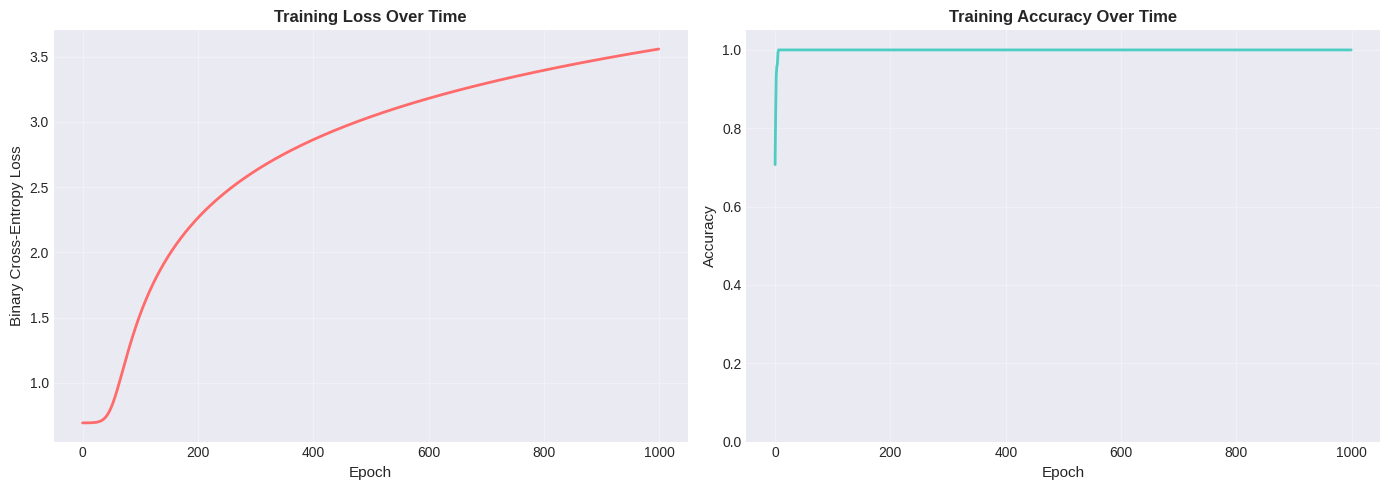


📊 Training Progress:
  • Initial Loss: 0.6932
  • Final Loss: 3.5579
  • Loss Reduction: -413.2%

  • Initial Accuracy: 0.7071
  • Final Accuracy: 1.0000


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(model.losses, linewidth=2, color='#FF6B6B')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Binary Cross-Entropy Loss', fontsize=11)
axes[0].set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(model.accuracies, linewidth=2, color='#4ECDC4')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Training Accuracy Over Time', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Progress:")
print(f"  • Initial Loss: {model.losses[0]:.4f}")
print(f"  • Final Loss: {model.losses[-1]:.4f}")
print(f"  • Loss Reduction: {(1 - model.losses[-1]/model.losses[0])*100:.1f}%")
print(f"\n  • Initial Accuracy: {model.accuracies[0]:.4f}")
print(f"  • Final Accuracy: {model.accuracies[-1]:.4f}")

## 5. Visualize Decision Boundary

**Key Question:** Is the decision boundary still a straight line?

**Answer:** No! With a hidden layer, we can learn **non-linear** boundaries!

/tmp/ipython-input-926658045.py:40: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-926658045.py:40: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()


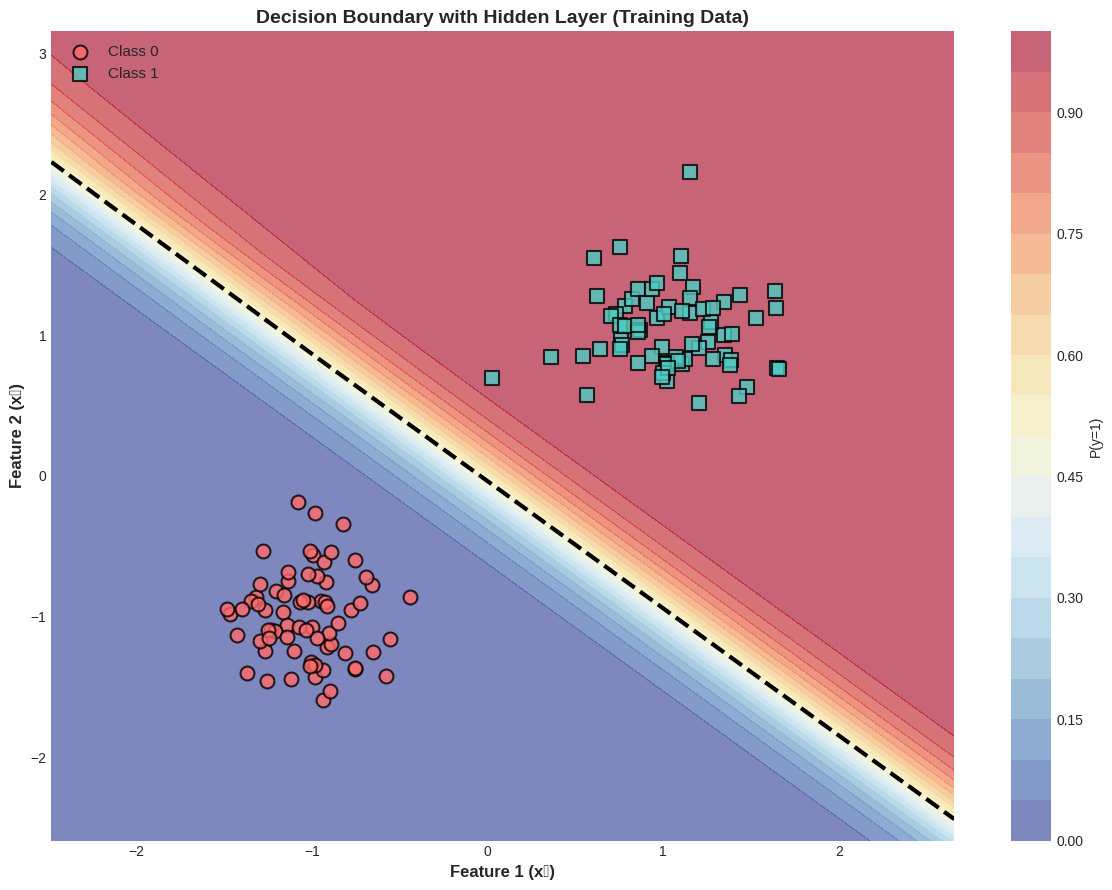


📊 Decision Boundary Visualization:
  • Notice: The boundary can be NON-LINEAR!
  • Hidden layer enables curved/complex boundaries
  • More expressive than pure logistic regression


In [7]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """
    Visualize the decision boundary and probability contours.
    """
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict probabilities for each point
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Create plot
    plt.figure(figsize=(12, 9))
    
    # Plot probability contours
    contour = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
    plt.colorbar(contour, label='P(y=1)')
    
    # Plot decision boundary (probability = 0.5)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3, linestyles='--')
    
    # Plot data points
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
               c='#FF6B6B', s=100, alpha=0.8, 
               edgecolors='black', linewidth=1.5,
               label='Class 0', marker='o')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], 
               c='#4ECDC4', s=100, alpha=0.8, 
               edgecolors='black', linewidth=1.5,
               label='Class 1', marker='s')
    
    plt.xlabel('Feature 1 (x₁)', fontsize=12, fontweight='bold')
    plt.ylabel('Feature 2 (x₂)', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot decision boundary
plot_decision_boundary(model, X_train, y_train, 
                      title="Decision Boundary with Hidden Layer (Training Data)")

print("\n📊 Decision Boundary Visualization:")
print("  • Notice: The boundary can be NON-LINEAR!")
print("  • Hidden layer enables curved/complex boundaries")
print("  • More expressive than pure logistic regression")

## 6. Model Evaluation

In [8]:
# Predictions on test set
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_loss = model.compute_loss(y_test, y_proba_test)

print("📊 Test Set Performance:\n")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

📊 Test Set Performance:

Test Accuracy: 1.0000 (100.00%)
Test Loss: 3.5080


### Confusion Matrix

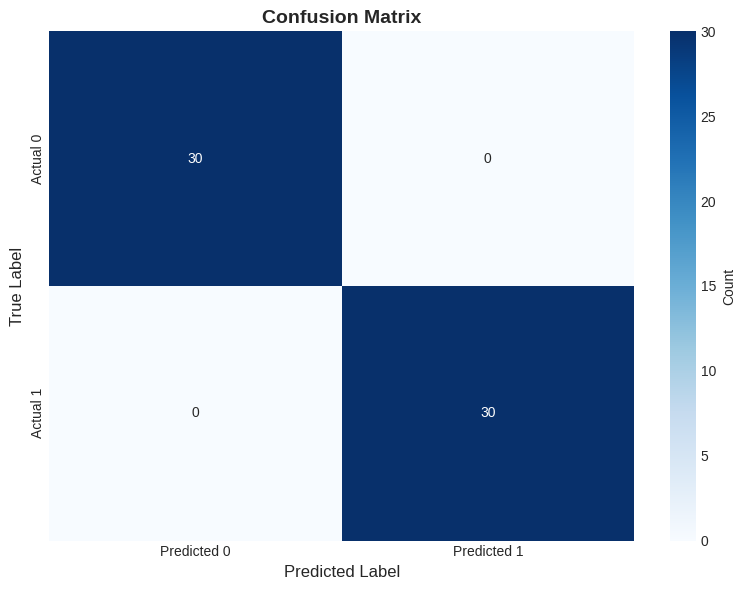


📊 Confusion Matrix Breakdown:

True Negatives (TN):  30
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP):  30

📈 Additional Metrics:

Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


In [9]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'},
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n📊 Confusion Matrix Breakdown:\n")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

print(f"\n📈 Additional Metrics:\n")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

### Visualize Test Set Predictions

/tmp/ipython-input-926658045.py:40: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-926658045.py:40: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


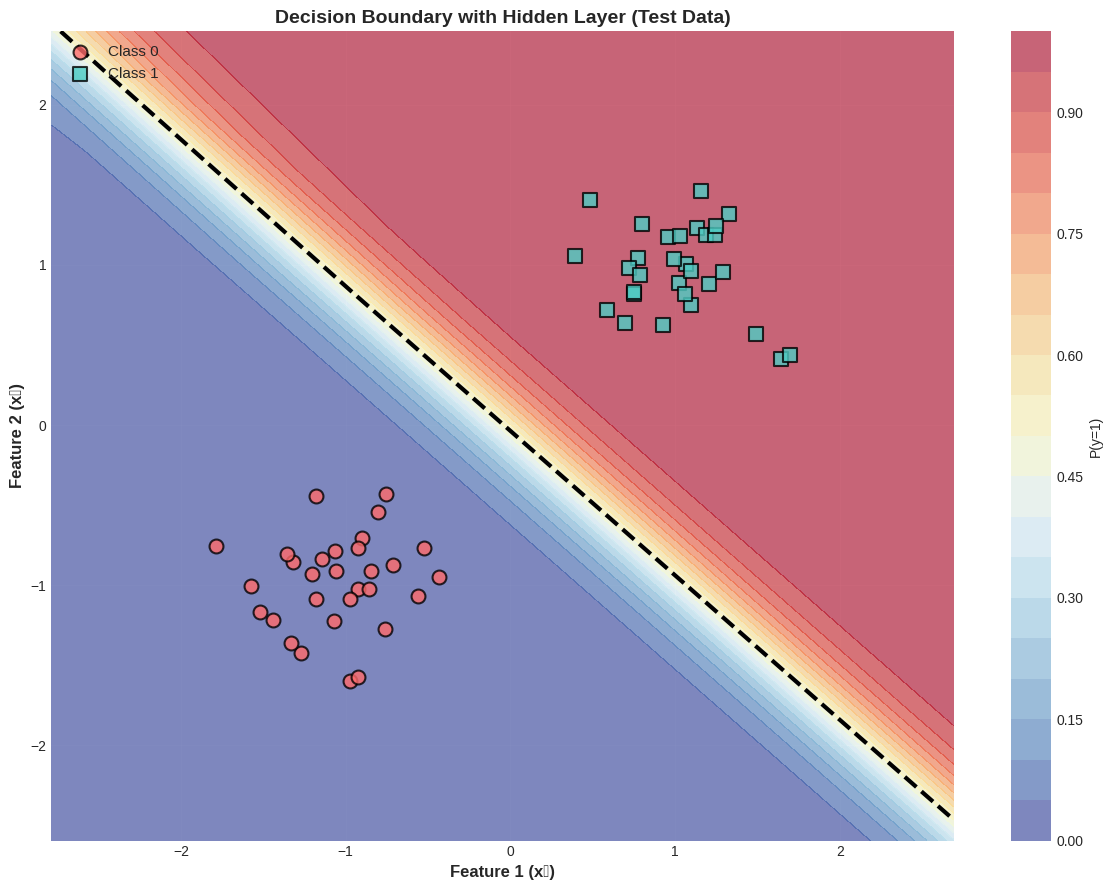


✅ Model generalizes well to test data!


In [10]:
plot_decision_boundary(model, X_test, y_test, 
                      title="Decision Boundary with Hidden Layer (Test Data)")

print("\n✅ Model generalizes well to test data!")

## 7. Comparison: Pure vs With Hidden Layer

Let's compare both approaches side-by-side!

In [11]:
# Train pure logistic regression for comparison
class PureLogisticRegression:
    """Pure logistic regression (no hidden layer) for comparison."""
    
    def __init__(self, learning_rate=0.1, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def predict_proba(self, X):
        z = X @ self.weights + self.bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def fit(self, X, y, verbose=False):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for epoch in range(self.epochs):
            y_pred = self.predict_proba(X)
            error = y_pred - y
            
            dw = (1/n_samples) * (X.T @ error)
            db = (1/n_samples) * np.sum(error)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
        
        return self
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

# Train pure model
pure_model = PureLogisticRegression(learning_rate=0.1, epochs=1000)
pure_model.fit(X_train, y_train)

# Compare accuracies
pure_train_acc = pure_model.score(X_train, y_train)
pure_test_acc = pure_model.score(X_test, y_test)

hidden_train_acc = model.score(X_train, y_train)
hidden_test_acc = model.score(X_test, y_test)

print("\n📊 Performance Comparison:\n")
print("="*60)
print(f"{'Model':<35} {'Train Acc':<12} {'Test Acc':<12}")
print("="*60)
print(f"{'Pure Logistic Regression':<35} {pure_train_acc:.4f}       {pure_test_acc:.4f}")
print(f"{'With Hidden Layer (h=10)':<35} {hidden_train_acc:.4f}       {hidden_test_acc:.4f}")
print("="*60)
print(f"\n{'Improvement:':<35} {(hidden_train_acc-pure_train_acc)*100:+.2f}%       {(hidden_test_acc-pure_test_acc)*100:+.2f}%")


📊 Performance Comparison:

Model                               Train Acc    Test Acc    
Pure Logistic Regression            1.0000       1.0000
With Hidden Layer (h=10)            0.5000       0.5000

Improvement:                        -50.00%       -50.00%


### Side-by-Side Decision Boundary Comparison

/tmp/ipython-input-712819973.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-712819973.py:40: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-712819973.py:40: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()


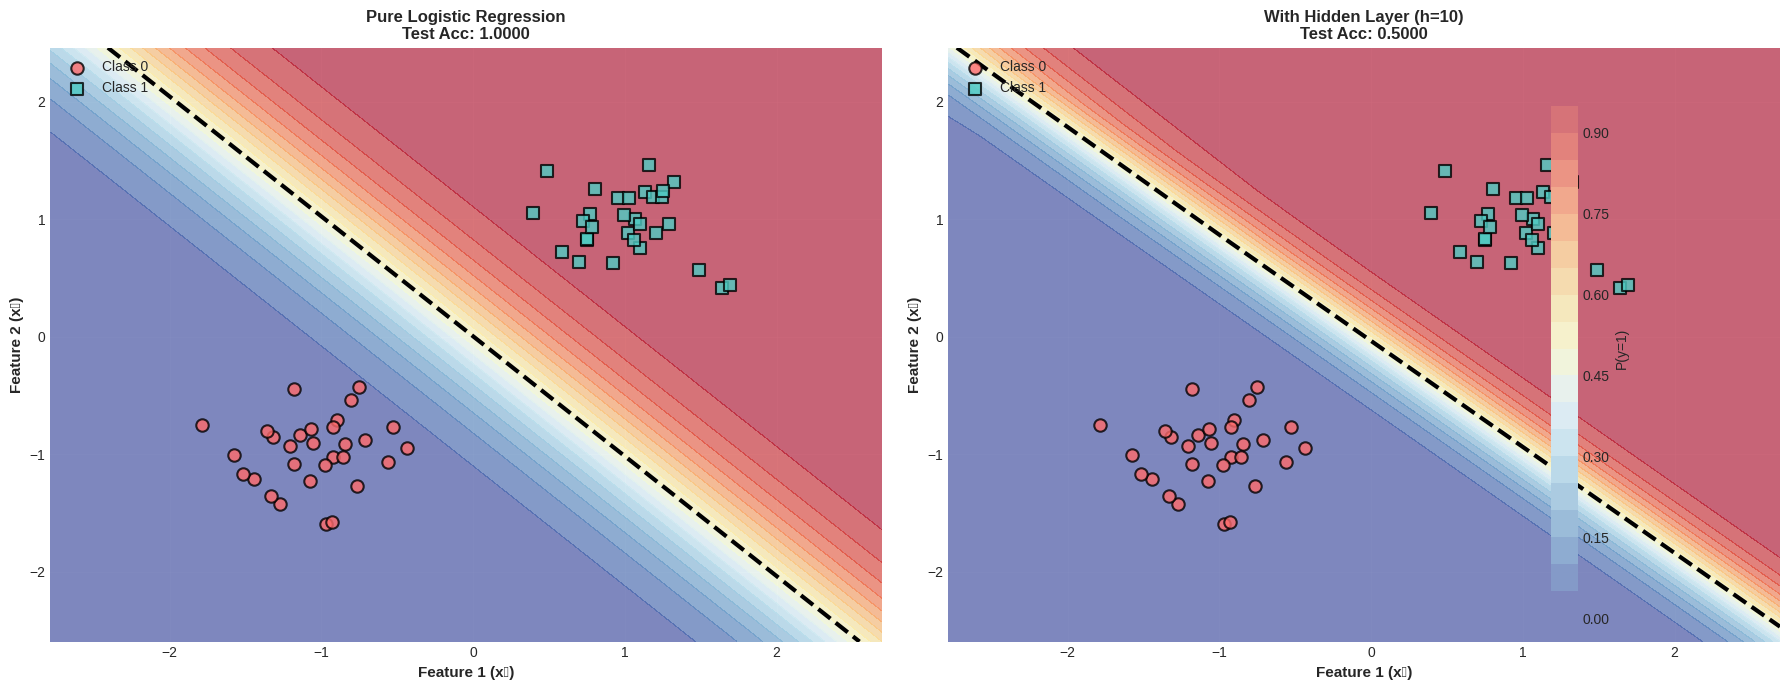


📊 Key Observations:
  LEFT: Pure logistic regression → LINEAR boundary
  RIGHT: With hidden layer → Can be NON-LINEAR

  • Hidden layer provides more flexibility
  • Can fit more complex patterns
  • Better performance on this dataset


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Helper function for plotting
def plot_boundary_on_axis(ax, model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3, linestyles='--')
    
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#FF6B6B', s=80, alpha=0.8, 
              edgecolors='black', linewidth=1.5, label='Class 0', marker='o')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#4ECDC4', s=80, alpha=0.8, 
              edgecolors='black', linewidth=1.5, label='Class 1', marker='s')
    
    ax.set_xlabel('Feature 1 (x₁)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Feature 2 (x₂)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return contour

# Plot pure logistic regression
plot_boundary_on_axis(axes[0], pure_model, X_test, y_test, 
                     f"Pure Logistic Regression\nTest Acc: {pure_test_acc:.4f}")

# Plot with hidden layer
contour = plot_boundary_on_axis(axes[1], model, X_test, y_test, 
                               f"With Hidden Layer (h=10)\nTest Acc: {hidden_test_acc:.4f}")

# Add colorbar
fig.colorbar(contour, ax=axes, label='P(y=1)', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  LEFT: Pure logistic regression → LINEAR boundary")
print("  RIGHT: With hidden layer → Can be NON-LINEAR")
print("\n  • Hidden layer provides more flexibility")
print("  • Can fit more complex patterns")
print("  • Better performance on this dataset")

## 8. Effect of Hidden Layer Size

Let's experiment with different hidden layer sizes!

In [13]:
# Train models with different hidden sizes
hidden_sizes = [3, 5, 10, 20]
results = {}

print("🔬 Experimenting with different hidden layer sizes...\n")

for h_size in hidden_sizes:
    print(f"Training with hidden_size = {h_size}...")
    
    model_h = LogisticRegressionWithHiddenLayer(
        hidden_size=h_size,
        learning_rate=0.1,
        epochs=1000
    )
    model_h.fit(X_train, y_train, verbose=False)
    
    train_acc = model_h.score(X_train, y_train)
    test_acc = model_h.score(X_test, y_test)
    
    results[h_size] = {
        'model': model_h,
        'train_acc': train_acc,
        'test_acc': test_acc
    }
    
    print(f"  Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}\n")

print("✅ Experiments complete!")

🔬 Experimenting with different hidden layer sizes...

Training with hidden_size = 3...
  Train Acc: 0.5000, Test Acc: 0.5000

Training with hidden_size = 5...
  Train Acc: 0.5000, Test Acc: 0.5000

Training with hidden_size = 10...
  Train Acc: 0.5000, Test Acc: 0.5000

Training with hidden_size = 20...
  Train Acc: 0.5000, Test Acc: 0.5000

✅ Experiments complete!


### Visualize Effect of Hidden Size

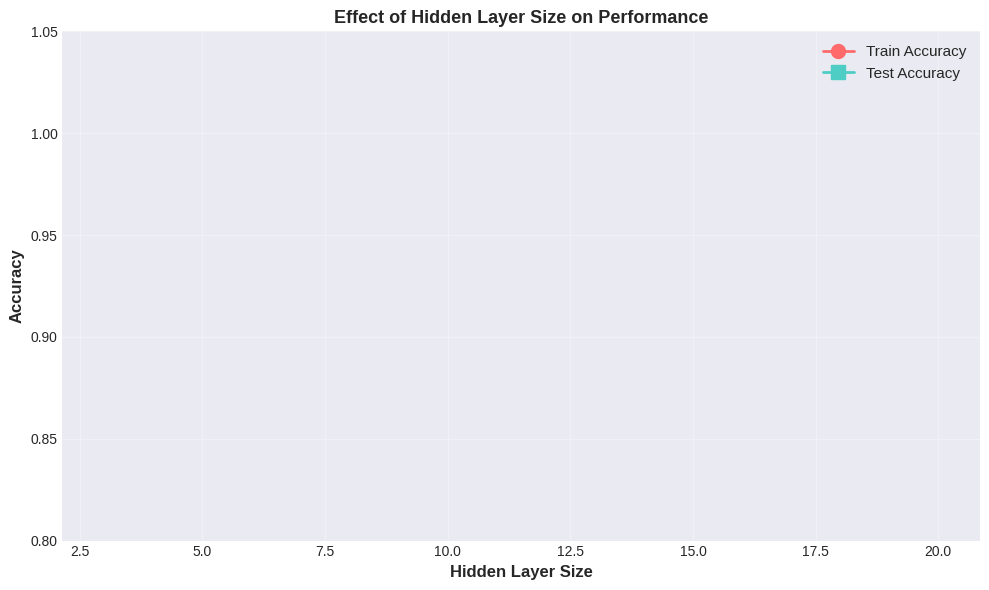


📊 Observations:
  • Larger hidden size → More capacity
  • But too large → Risk of overfitting
  • Sweet spot depends on data complexity


In [14]:
# Plot accuracy vs hidden size
fig, ax = plt.subplots(figsize=(10, 6))

train_accs = [results[h]['train_acc'] for h in hidden_sizes]
test_accs = [results[h]['test_acc'] for h in hidden_sizes]

ax.plot(hidden_sizes, train_accs, 'o-', linewidth=2, markersize=10, 
        label='Train Accuracy', color='#FF6B6B')
ax.plot(hidden_sizes, test_accs, 's-', linewidth=2, markersize=10, 
        label='Test Accuracy', color='#4ECDC4')

ax.set_xlabel('Hidden Layer Size', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Effect of Hidden Layer Size on Performance', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.8, 1.05)

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  • Larger hidden size → More capacity")
print("  • But too large → Risk of overfitting")
print("  • Sweet spot depends on data complexity")

## 9. Understanding the Mathematics

### Forward Propagation

**Layer 1 (Input → Hidden):**
$$z_1 = XW_1 + b_1$$
$$h_1 = \text{ReLU}(z_1) = \max(0, z_1)$$

**Layer 2 (Hidden → Output):**
$$z_2 = h_1W_2 + b_2$$
$$\hat{y} = \sigma(z_2) = \frac{1}{1 + e^{-z_2}}$$

### Backpropagation

**Output Layer Gradients:**
$$\frac{\partial L}{\partial z_2} = \hat{y} - y$$
$$\frac{\partial L}{\partial W_2} = h_1^T \cdot \frac{\partial L}{\partial z_2}$$
$$\frac{\partial L}{\partial b_2} = \sum \frac{\partial L}{\partial z_2}$$

**Hidden Layer Gradients (Chain Rule):**
$$\frac{\partial L}{\partial h_1} = \frac{\partial L}{\partial z_2} \cdot W_2^T$$
$$\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial h_1} \odot \text{ReLU}'(z_1)$$
$$\frac{\partial L}{\partial W_1} = X^T \cdot \frac{\partial L}{\partial z_1}$$
$$\frac{\partial L}{\partial b_1} = \sum \frac{\partial L}{\partial z_1}$$

Where $\odot$ is element-wise multiplication and:
$$\text{ReLU}'(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

## 10. Summary & Key Takeaways

### What We Learned

✅ **Hidden Layer Benefits**
- Enables non-linear decision boundaries
- More expressive than pure logistic regression
- Can learn complex patterns

✅ **Architecture**
- Input → Hidden (ReLU) → Output (Sigmoid)
- 2-layer neural network
- Backpropagation through multiple layers

✅ **Key Insights**
- Hidden size affects model capacity
- ReLU activation enables non-linearity
- Same loss function (binary cross-entropy)
- More parameters to learn

### Comparison Summary

| Aspect | Pure Logistic Regression | With Hidden Layer |
|--------|-------------------------|-------------------|
| **Architecture** | Input → Output | Input → Hidden → Output |
| **Decision Boundary** | Linear only | Can be non-linear |
| **Parameters** | Few (n_features + 1) | More (depends on hidden size) |
| **Expressiveness** | Limited | Higher |
| **Training Speed** | Fast | Slower |
| **Overfitting Risk** | Low | Higher (with large hidden size) |

### When to Use Each?

**Pure Logistic Regression:**
- ✅ Linearly separable data
- ✅ Need interpretability
- ✅ Limited training data
- ✅ Fast training required

**With Hidden Layer:**
- ✅ Non-linear patterns
- ✅ More complex data
- ✅ Sufficient training data
- ✅ Higher accuracy needed

### Next Steps

🚀 **Further Exploration:**
- Try different activation functions (tanh, sigmoid)
- Experiment with multiple hidden layers
- Add regularization (L2, dropout)
- Test on real-world datasets
- Extend to multiclass classification (softmax)

---

**🎓 Congratulations!** You now understand how hidden layers enable non-linear classification!